In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CelebA
from torchvision.transforms import ToTensor, Compose, CenterCrop, Normalize
from tqdm import tqdm
from matplotlib import pyplot as plt

dev = 'cpu'

In [3]:
train_set = CelebA('./dataset', split='train', transform=Compose([
        CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

val_set = CelebA('./dataset', split='test', transform=Compose([
        CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

Files already downloaded and verified
Files already downloaded and verified


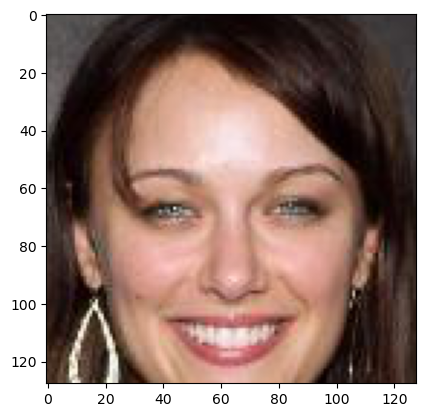

In [4]:
def showimgs(imgs):
    #plt.figure(figsize=(20, 10))
    imgs = imgs.movedim((0, 2, 3, 1), (0, 1, 2, 3))
    imgs = np.concatenate(imgs.detach().numpy().tolist(), axis=1)
    imgs = (imgs + 1)/2
    plt.imshow(imgs)


#img, label = train_set[np.random.randint(0, len(train_set))]

BS = 1
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
batch, _ = next(iter(train_loader))
showimgs(batch[:10])

In [9]:
from model import DenoisingDiffusion
model = DenoisingDiffusion(diffusion_steps=100).to(dev)
n = model.forward_process(batch)
#showimgs(n)
sum(param.numel() for param in model.parameters())\
# 141 385 702
# 135 577 830
# 307 323 110
# 285 823 974:114

# 221 256 678
# 209 693 478
# 43 144 262
# 88 305 446
# 99 868 646

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1552.00it/s]


141385702

In [ ]:
showimgs(img := model.backward_process(n))

 27%|██████████████████████▋                                                             | 27/100 [00:29<01:22,  1.13s/it]